# Estimating growth rate in the households model

In this notebook, we start by running the UK SEPIR households example and estimating the growth rate directly. We then look at ways we can estimate it without directly solving the equations.

In [1]:
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from numpy import arange, argmin, array, diag,  log, ones, where, zeros
from numpy.linalg import eig
from scipy.sparse import eye, identity
from scipy.sparse import csc_matrix as sparse
from scipy.sparse.linalg import inv
from time import time as get_time

In [2]:
from os import chdir, getcwd
current_dir = getcwd()
if current_dir[-9:] == 'tutorials':
    chdir('..')

The following block is just copy-pasted from the examples folder:

In [3]:
from os.path import isfile
from pickle import load, dump
from pandas import read_csv
from scipy.integrate import solve_ivp
from model.preprocessing import (
        SEPIRInput, HouseholdPopulation, make_initial_condition)
from model.specs import TWO_AGE_SEPIR_SPEC, TWO_AGE_UK_SPEC
from model.common import SEPIRRateEquations
from model.imports import NoImportModel
# pylint: disable=invalid-name

SPEC = {**TWO_AGE_SEPIR_SPEC, **TWO_AGE_UK_SPEC}

# List of observed household compositions
composition_list = read_csv(
    'inputs/eng_and_wales_adult_child_composition_list.csv',
    header=0).to_numpy()
# Proportion of households which are in each composition
comp_dist = read_csv(
    'inputs/eng_and_wales_adult_child_composition_dist.csv',
    header=0).to_numpy().squeeze()

model_input = SEPIRInput(SPEC, composition_list, comp_dist)

household_population = HouseholdPopulation(
        composition_list, comp_dist, model_input)

rhs = SEPIRRateEquations(model_input, household_population, NoImportModel(5,2))

H0 = make_initial_condition(household_population, rhs)

tspan = (0.0, 365)
solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16)

time = solution.t
H = solution.y
S = H.T.dot(household_population.states[:, ::5])
E = H.T.dot(household_population.states[:, 1::5])
P = H.T.dot(household_population.states[:, 2::5])
I = H.T.dot(household_population.states[:, 3::5])
R = H.T.dot(household_population.states[:, 4::5])
time_series = {
'time':time,
'S':S,
'E':E,
'P':P,
'I':I,
'R':R
}


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.31it/s]


In the next block, we plot the log of the mean "active" infections ($E+P+I$) over time, and the log of the total proportion of households containing an infection $H(\vec{X}:(E+P+I)(\vec{X})>0)$. Comparing the linear segment of these plots, we can see that during the exponential growth phase of the epidemic, the household growth rate is the same as the individual-level growth rate, exactly as predicted by theory.

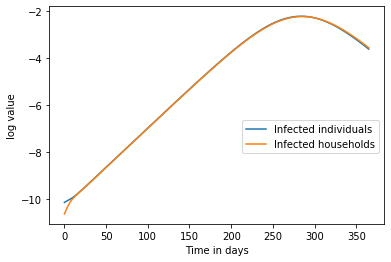

In [4]:
data_list = [time_series['S']/model_input.ave_hh_by_class,
    time_series['E']/model_input.ave_hh_by_class,
    time_series['P']/model_input.ave_hh_by_class,
    time_series['I']/model_input.ave_hh_by_class,
    time_series['R']/model_input.ave_hh_by_class]

log_infs = log((data_list[1]+data_list[2]+data_list[3]).sum(axis=1))
inf_states = where((rhs.states_exp_only + rhs.states_pro_only + rhs.states_inf_only).sum(axis=1)>0)[0]

fig, ax = subplots(1)

ax.plot(time, log_infs,label='Infected individuals')
ax.plot(time, log((H[inf_states]).sum(axis=0)),label='Infected households')
ax.set_xlabel('Time in days')
ax.set_ylabel('log value')
ax.legend(ncol=1, bbox_to_anchor=(1,0.50))

By inspection of the plots, we can see that around day 50 the epidemic is definitely in its exponential growth phase. In the next box we work out which increment of the solver is closest to day 50, then directly calculate the gradient of the log growth curve at this time step, giving us an estimate of the exponential growth rate.

In [5]:
t_50 = argmin(abs(time - 50))
print('Closest time to 50 days is at increment',t_50,', t[',t_50,']=',time[t_50],'.')
r_guess = (log_infs[51]-log_infs[50])/(time[51]-time[50])
print('Direct estimate of log gradient at increment',t_50,'is',r_guess,'.')

Closest time to 50 days is at increment 32 , t[ 32 ]= 50.37318700806596 .
Direct estimate of log gradient at increment 32 is 0.033352589041851476 .


## Growth rate calculations

We will use an Euler-Lotka approach to do growth rate calculations. Suppose we are in the exponential growth phase of our dynamics. Let $\underline{I}$ be the profile of households typed by composition and risk class of index case, i.e. if infectious households of type $i$ have composition $\underline{N}(i)$ and an index case in risk class $C(i)$, then $I_i$ is the proportion of infected households in this growth phase which are in composition $\underline{N}(i)$ and had their local outbreak seeded by a case in risk class $C(i)$. In the exponential growth phase, this grows according to
$$
\frac{\mathrm{d}\underline{I}}{\mathrm{d}t} = e^{rt}\underline{I}_*,
$$
where $\underline{I}_*$ is the unit eigenvector. If $\underline{\underline{\lambda}}(a)$ is the matrix with $(i,j)$th entry giving the rate at which a household of composition-seed type $i$ generates those of composition-seed type $j$ at time $a$ since its original import, then we get the following Euler-Lotka equation
$$
\underline{I}_* = \int\limits_0^{\infty}\underline{I}_* e^{-r\underline{\underline{In}}t}\underline{\underline{\lambda}}\mathrm{d}t.
$$
Assuming we do not see repeat introductions of infection into a single household, we can decompose $\underline{\underline{\lambda}}$ as follows:
$$
\underline{\underline{\lambda}} = \underline{\underline{\alpha}}e^{\underline{\underline{Q}}_{\mathrm{int}}t}\underline{\underline{F}}\underline{\underline{P}}.
$$
Here $\underline{\underline{\alpha}}$ is the matrix mapping composition and import class of household to an initial condition in the households model, $\underline{\underline{F}}$ is infection rate to each class from each composition, and $\underline{\underline{P}}$ is probability that the infection kicked out to a given class ends up in a given type of household. The term $e^{\underline{\underline{Q}}_{\mathrm{int}}t}$ gives the evolution of the within-household system, derived from the fact that we are assuming that after an import there is no other interaction with external households, so the evolution is linear. The Euler-Lotka equation is then
$$
\underline{I}_* = \int\limits_0^{\infty}\underline{I}_* \underline{\underline{\alpha}} e^{(underline{\underline{Q}}_{\mathrm{int}}-r\underline{\underline{In}})t}\underline{\underline{F}}\underline{\underline{P}}\mathrm{d}t,
$$
and integrating we get
$$
\underline{I}_* = \underline{I}_* \underline{\underline{\alpha}} (r\underline{\underline{In}}-underline{\underline{Q}}_{\mathrm{int}})\underline{\underline{F}}\underline{\underline{P}}.
$$
This is an eigenvector formula with eigenvalue 1, so to find the growth rate, we need to find $r$ such that the transpose of
$$
\underline{\underline{\alpha}} (r\underline{\underline{In}}-underline{\underline{Q}}_{\mathrm{int}})\underline{\underline{F}}\underline{\underline{P}}
$$
has leading(?) eigenvalue 1 (cf Pellis, Ferguson and Fraser on households-workplaces models). Because $\underline{\underline{F}}$ scales linearly with the baseline between-household transmission, so estimate between-household transmission we just need to put in a guess, calculate the leading eigenvalue of the compound matrix, then scale the guess by the reciprocal of this eigenvalue to give us a between-household transmission rate which gives us the oberved growth rate. Alternatively, to calculate $r$ based on some parameters, we can just do something like interval bisection in 1D.

In the boxes below, we calculate all the components of this matrix for our UK SEPIR model example.

The following block creates a matrix `reverse_comp_dist` containing the probability that an individual in a given age class is in a household of a given composition - this is a component of our $\underline{\underline{P}}$ matrix.

In [6]:
no_risk_classes = composition_list.shape[1]

reverse_comp_dist = diag(comp_dist).dot(composition_list)
reverse_comp_dist = reverse_comp_dist.dot(diag(1/reverse_comp_dist.sum(0)))

In the following block, `Q_int` is internal evolution matrix, `FOI_by_state` gives expected infection kicked out by a household in a given state (the $\underline{\underline{F}}$ matrix).

In [7]:
Q_int = rhs.Q_int

FOI_by_state = zeros((Q_int.shape[0],no_risk_classes))

for ic in range(rhs.no_inf_compartments):
            states_inf_only =  rhs.inf_by_state_list[ic]
            FOI_by_state += (rhs.ext_matrix_list[ic].dot(
                    rhs.epsilon * states_inf_only.T)).T

In [8]:
index_states = where(
    ((rhs.states_exp_only.sum(axis=1)==1) * 
    ((rhs.states_pro_only + rhs.states_inf_only + rhs.states_rec_only).sum(axis=1)==0)))[0]

no_index_states = len(index_states)
comp_by_index_state = household_population.which_composition[index_states]

The next box creates $\underline{\underline{\alpha}}$

In [9]:
starter_mat = sparse((ones(no_index_states),(range(no_index_states), index_states)),shape=(no_index_states,Q_int.shape[0]))

Next matrix is "probability that an index case in class c results in outbreak in index state i", i.e. $\underline{\underline{P}}$:

In [10]:
index_prob = zeros((no_risk_classes,no_index_states))
for i in range(no_index_states):
    index_class = where(rhs.states_exp_only[index_states[i],:]==1)[0]
    index_prob[index_class,i] = reverse_comp_dist[comp_by_index_state[i], index_class]

The next box combines all this together to give us
$$
\underline{\underline{\alpha}} (r\underline{\underline{In}}-underline{\underline{Q}}_{\mathrm{int}})\underline{\underline{F}}\underline{\underline{P}}.
$$

In [11]:
def get_multiplier(r):
    inv_diff = inv(r * identity(Q_int.shape[0]) - Q_int)
    step_1 = FOI_by_state.dot(index_prob)
    step_2 = inv_diff.dot(step_1)
    step_3 = starter_mat.dot(step_2)
    step_4 = step_3
    return step_4

In the boxes below, we empirically calculate the growth rate at each time increment and plot its value over time.

In [12]:
no_tsteps = len(time)
r_range = zeros(no_tsteps-1,)
for tstep in range(no_tsteps-1):
    r_range[tstep] = (log_infs[tstep+1]-log_infs[tstep])/(time[tstep+1]-time[tstep])

Text(0, 0.5, 'Empirical growth rate')

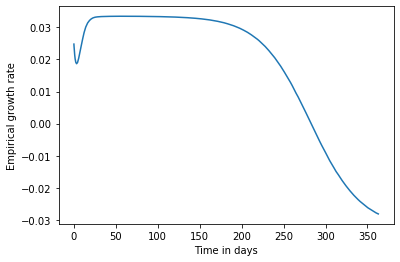

In [13]:
fig, ax = subplots(1)

ax.plot(time[:-1], r_range)
ax.set_xlabel('Time in days')
ax.set_ylabel('Empirical growth rate')

Now estimate the eigenvalue of the multiplier over time based on the growth rates calculated above - note that we need to take its transpose since we did the Euler-Lotka stuff with respect to column vectors.

In [14]:
short_len = int(no_tsteps/10)
multiplier_list = []
evals = zeros(short_len,)

start_time = get_time()

for i in range(short_len):
    multiplier_now = get_multiplier(r_range[10*i])
    multiplier_list.append(multiplier_now)
    evals[i] = eig(multiplier_now.T)[0][0]
    
    time_now = get_time()
    print(i,
          'of',
          short_len,
          'calculations completed',
          time_now-start_time,
          'seconds elapsed,estimated',
         (short_len-(i+1))*(time_now-start_time)/(i+1),
         'seconds remaining.')

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


0 of 16 calculations completed 0.07951474189758301 seconds elapsed,estimated 1.1927211284637451 seconds remaining.
1 of 16 calculations completed 0.18014121055603027 seconds elapsed,estimated 1.260988473892212 seconds remaining.


C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


2 of 16 calculations completed 0.2773258686065674 seconds elapsed,estimated 1.2017454306284587 seconds remaining.
3 of 16 calculations completed 0.3692493438720703 seconds elapsed,estimated 1.107748031616211 seconds remaining.
4 of 16 calculations completed 0.46419620513916016 seconds elapsed,estimated 1.0212316513061523 seconds remaining.
5 of 16 calculations completed 0.5671613216400146 seconds elapsed,estimated 0.9452688694000244 seconds remaining.
6 of 16 calculations completed 0.6690785884857178 seconds elapsed,estimated 0.8602438994816372 seconds remaining.
7 of 16 calculations completed 0.7670450210571289 seconds elapsed,estimated 0.7670450210571289 seconds remaining.
8 of 16 calculations completed 0.8619930744171143 seconds elapsed,estimated 0.6704390578799777 seconds remaining.
9 of 16 calculations completed 0.9579377174377441 seconds elapsed,estimated 0.5747626304626465 seconds remaining.
10 of 16 calculations completed 1.0546979904174805 seconds elapsed,estimated 0.479408177

We now plot the leading eigenvalue of the multiplier.

Text(0, 0.5, 'Leading eigenvalue of multiplier')

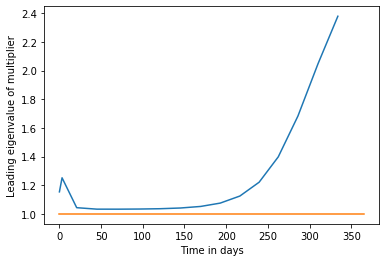

In [15]:
fig, ax = subplots(1)

ax.plot(time[10*arange(short_len)], evals)
ax.plot([time[0],time[-1]],[1,1])
ax.set_xlabel('Time in days')
ax.set_ylabel('Leading eigenvalue of multiplier')

This isn't quite equal to 1 in the exponential growth phase. Unclear currently whether this is a numerical error or an actual mistake.